In [2]:
import sys
import os

project_root = os.path.abspath("..")  # Adjust if needed
sys.path.append(project_root)


In [4]:
from newsies.chromadb_client import ChromaDBClient
from newsies.collections import TAGS

In [44]:
client = ChromaDBClient()
client.collection_name = TAGS
ngram_count = client.collection.count()
print(f"{ngram_count} ngrams found in chromadb")

42419 ngrams found in chromadb


In [45]:
ngrams = client.collection.get(include=["metadatas"])

In [46]:
metadatas = ngrams["metadatas"]

In [47]:
import json

In [48]:
for i,v in enumerate(metadatas):
    metadatas[i]["sections"] = json.loads(metadatas[i]["sections"])

In [49]:
metadatas[1]

{'most_likely_section': 'oddities',
 'ngram': 'The',
 'sections': {'science': 478,
  'health': 932,
  'entertainment': 411,
  'oddities': 303,
  'technology': 427,
  'us-news': 426,
  'world-news': 543,
  'sports': 497,
  'business': 360,
  'politics': 377},
 'tfidf': '{"science": 5.909554277808224, "health": 6.269358130764565, "entertainment": 5.032086165711986, "oddities": 9.046978491770513, "technology": 6.374686164993414, "us-news": 7.81604937627377, "world-news": 3.343516765094369, "sports": 7.069572750449871, "business": 7.303729780104145, "politics": 2.7272822592221275}'}

In [60]:
from collections import Counter
from newsies.ap_news import SECTIONS
ng_counter = Counter()
for section in SECTIONS:
    ng_counter[section] += 0



In [61]:
for meta in metadatas:
    for k,v in meta["sections"].items():
        ng_counter[k]+=v

In [62]:
ng_counter.pop("")
print(ng_counter)

Counter({'health': 105143, 'world-news': 86341, 'technology': 63083, 'entertainment': 59715, 'science': 56550, 'sports': 55317, 'us-news': 54019, 'politics': 53255, 'business': 45842, 'oddities': 43602})


In [63]:
from matplotlib import pyplot as plt



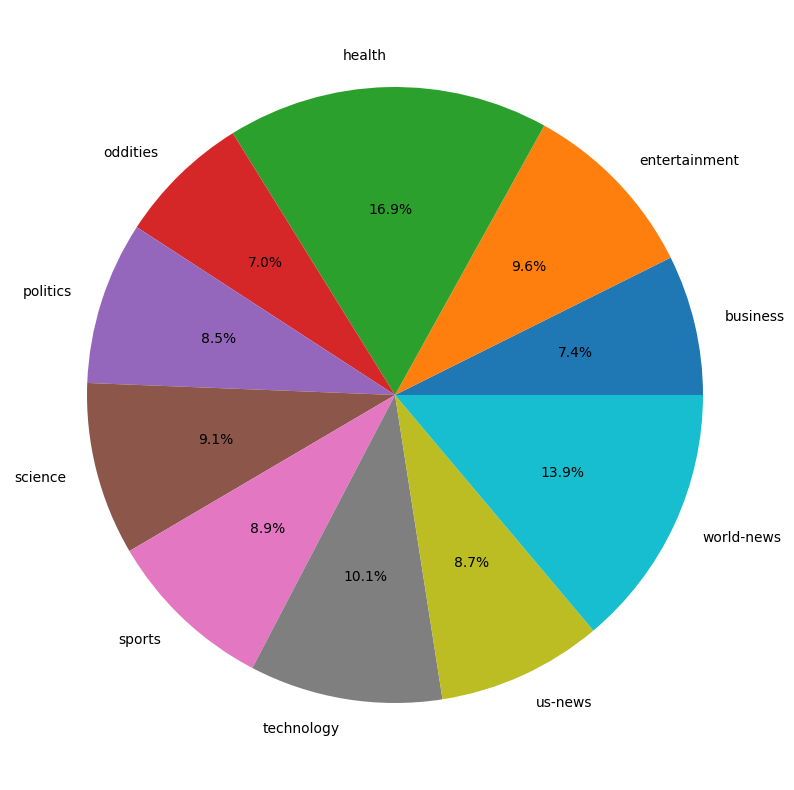

In [64]:
labels = list(ng_counter.keys())
labels.sort()
data = [ng_counter[l] for l in labels]
fig = plt.figure(figsize=(10,10))
plt.pie(data, labels=labels, autopct=r"%1.1f%%" )
plt.show()

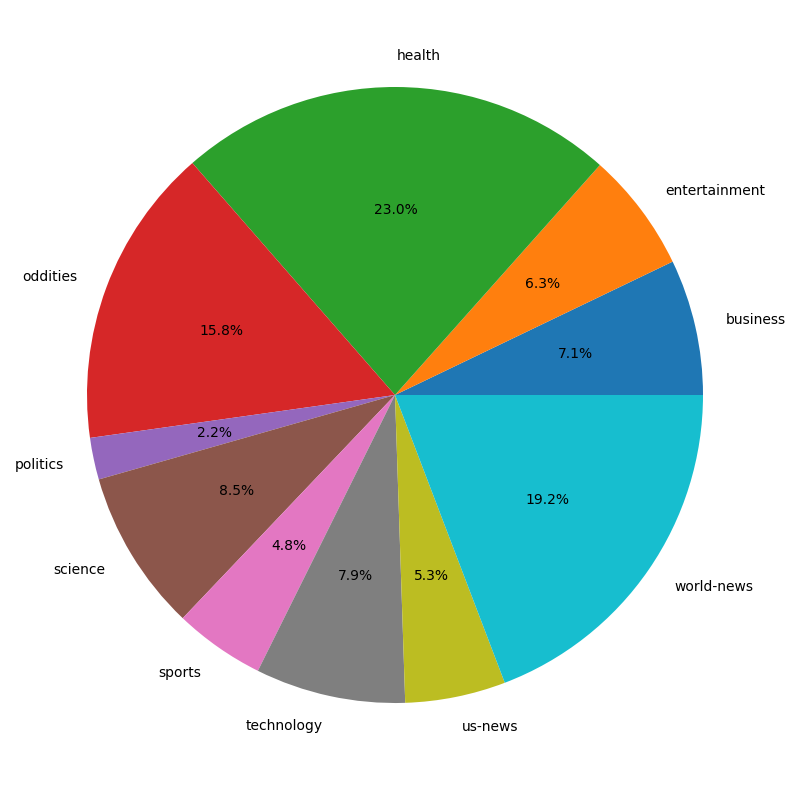

In [65]:
best = Counter()
for section in SECTIONS:
    best[section]=0

for meta in metadatas:
    best[meta["most_likely_section"]] += 1

data = [best[l] for l in labels]
fig = plt.figure(figsize=(10,10))
plt.pie(data, labels=labels, autopct=r"%1.1f%%" )
plt.show()

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from chromadb import Client
import seaborn as sns

def visualize_query_distribution(prompt: str, top_n: int = 10):
    """
    Generates a radar chart (spiderweb map) visualizing TF-IDF scores per section
    for a given prompt query in ChromaDB.

    :param prompt: The query string to analyze.
    :param top_n: Number of top sections to display.
    """

    # Load embedding model
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    prompt_embedding = embedding_model.encode(prompt).tolist()

    # Connect to ChromaDB
    chroma_client = ChromaDBClient()
    chroma_client.collection_name = TAGS

    # Query ChromaDB
    results = chroma_client.collection.query(
        query_embeddings=[prompt_embedding],
        n_results=100  # Fetch top 100 matching ngrams
    )

    # Aggregate TF-IDF scores by section
    section_scores = defaultdict(float)
    for metadata in results["metadatas"][0]:  # Assuming a single query, hence index [0]
        if "tfidf" in metadata:
            section_tfidf = json.loads(metadata["tfidf"])  # Convert from JSON
            for section, tfidf in section_tfidf.items():
                section_scores[section] += tfidf  # Accumulate scores

    # Get top N sections
    sorted_sections = sorted(section_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    if not sorted_sections:
        print("No relevant sections found for visualization.")
        return

    labels, values = zip(*sorted_sections)

    # Normalize scores (0 to 1 scale)
    max_score = max(values) if values else 1
    values = [v / max_score for v in values]

    # Create circular data structure for radar chart
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    values += values[:1]  # Close the circular plot
    angles += angles[:1]  # Close the circular plot

    # Configure plot aesthetics
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Draw the radar chart
    ax.fill(angles, values, color="blue", alpha=0.3)
    ax.plot(angles, values, color="blue", linewidth=2)

    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)

    # Title
    plt.title(f"Query Distribution for: {prompt}", fontsize=14, fontweight="bold")

    plt.show()




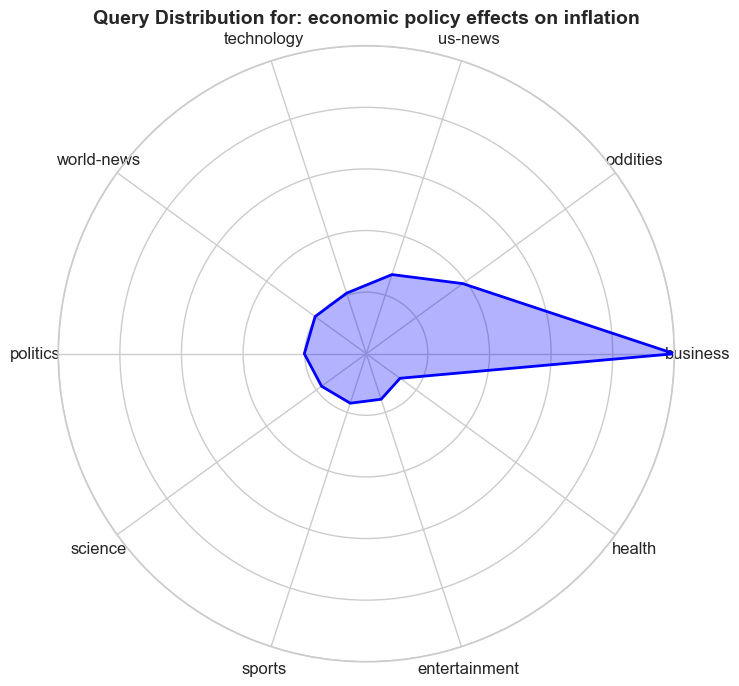

In [67]:
# Example usage
visualize_query_distribution("economic policy effects on inflation")

In [68]:
test_data = [
    ("are there any stories about Wyoming", ["us-news"]),
    ("are there any stories about Blue Origin", ["science"]),
    ("I want the most recent story about the Oscar awards", ["entertainment"]),
    ("any updates on Canada's response to US tariffs?", ["business", "world-news"]),
    ("any news about robotics or AI?", ["technology"]),
    (
        "are there any actors appearing in more than one movie right now?",
        ["entertainment"],
    ),
    (
        "what are reactions to JD Vance's white house debacle?",
        ["us-news", "politics"],
    ),
    (
        "trump doge downsizing of food and drug administration",
        ["health"],
    ),
    ("what are stores doing to battle inflation", ["business"]),
]

are there any stories about Wyoming ['us-news']


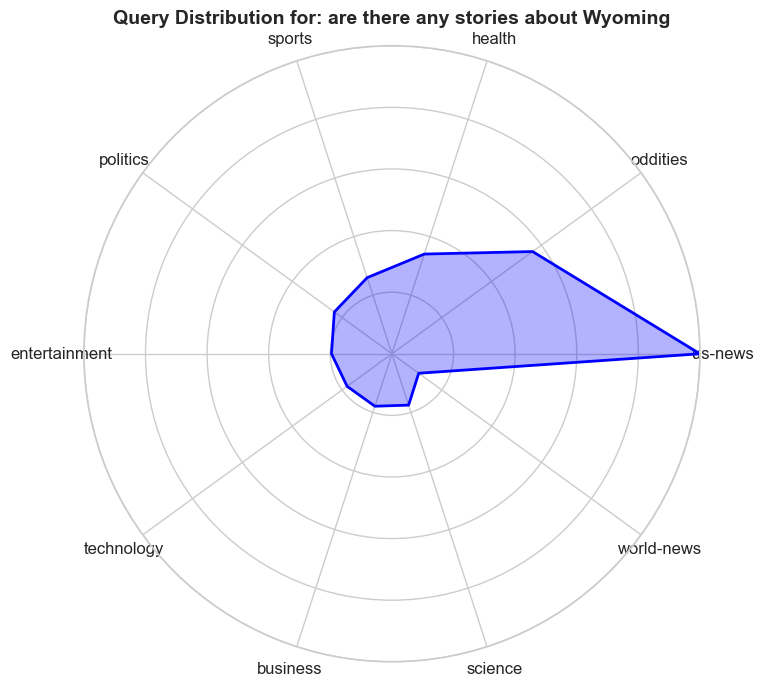


are there any stories about Blue Origin ['science']


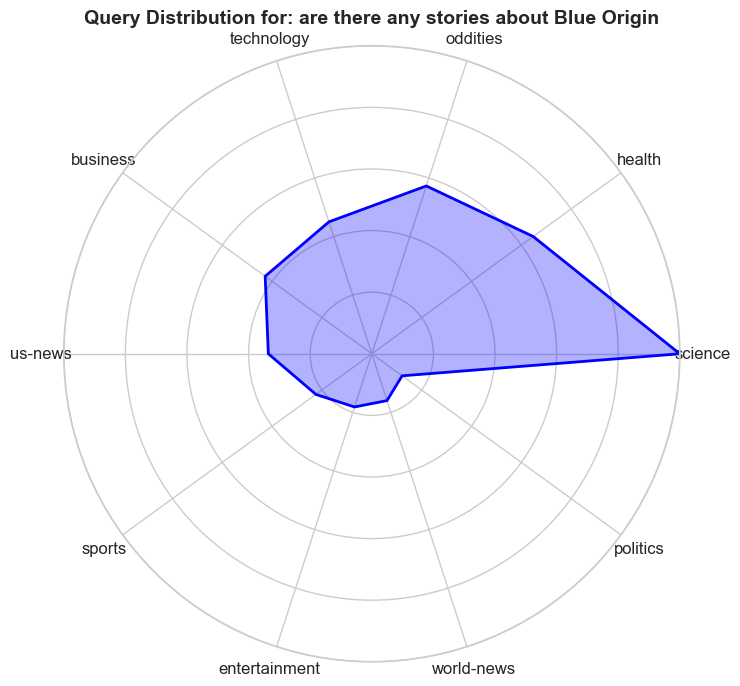


I want the most recent story about the Oscar awards ['entertainment']


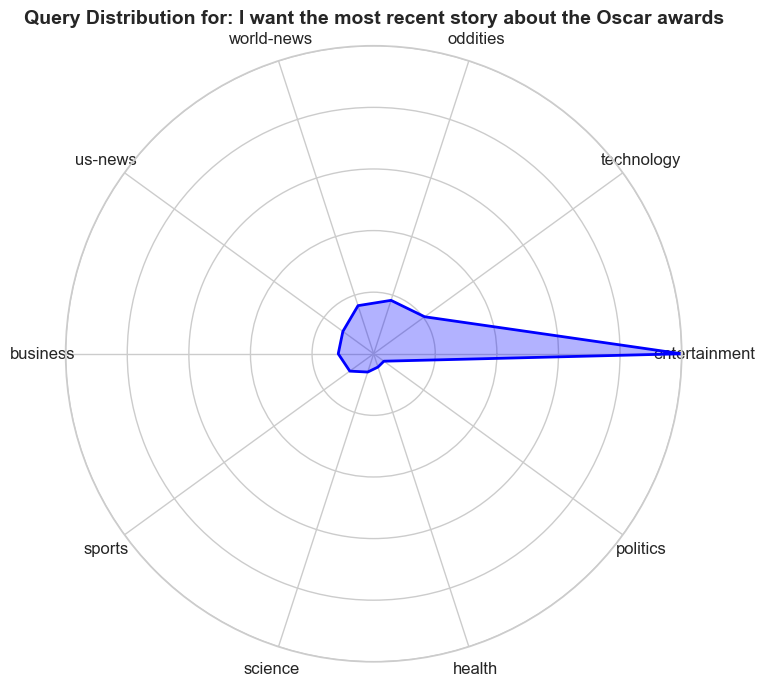


any updates on Canada's response to US tariffs? ['business', 'world-news']


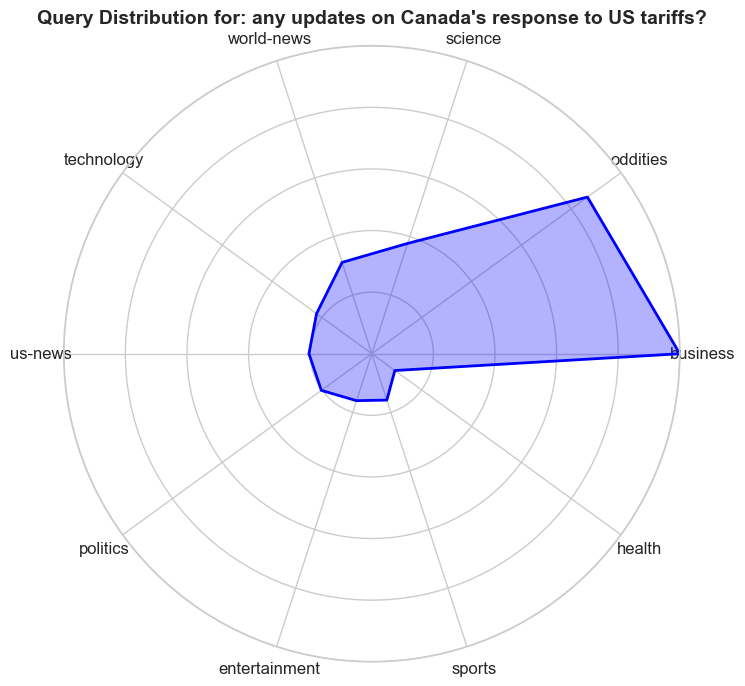


any news about robotics or AI? ['technology']


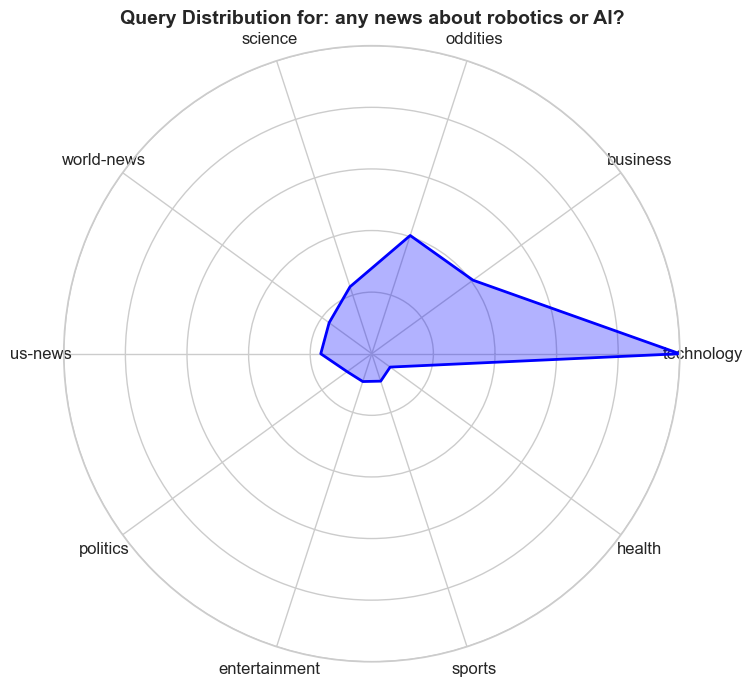


are there any actors appearing in more than one movie right now? ['entertainment']


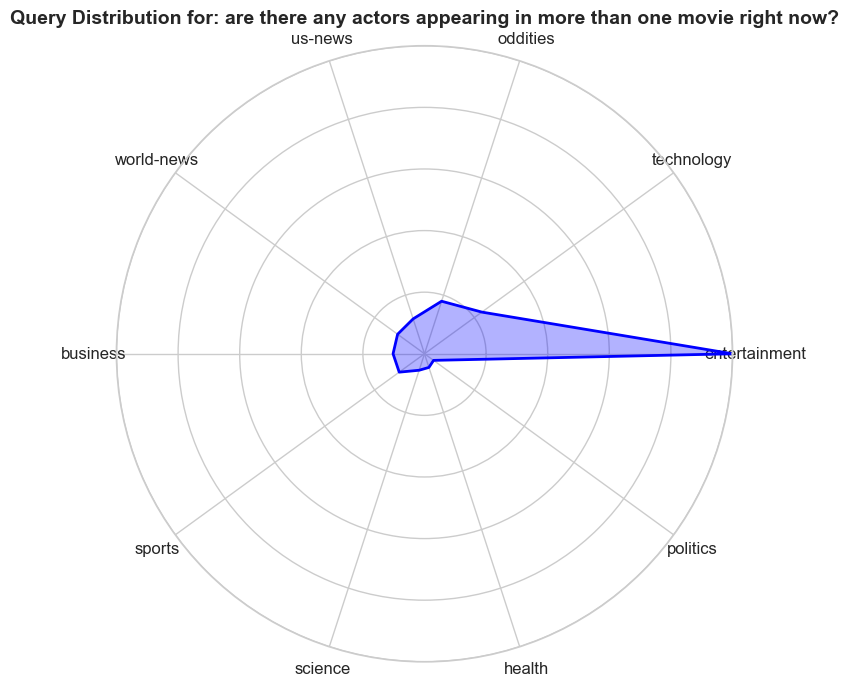


what are reactions to JD Vance's white house debacle? ['us-news', 'politics']


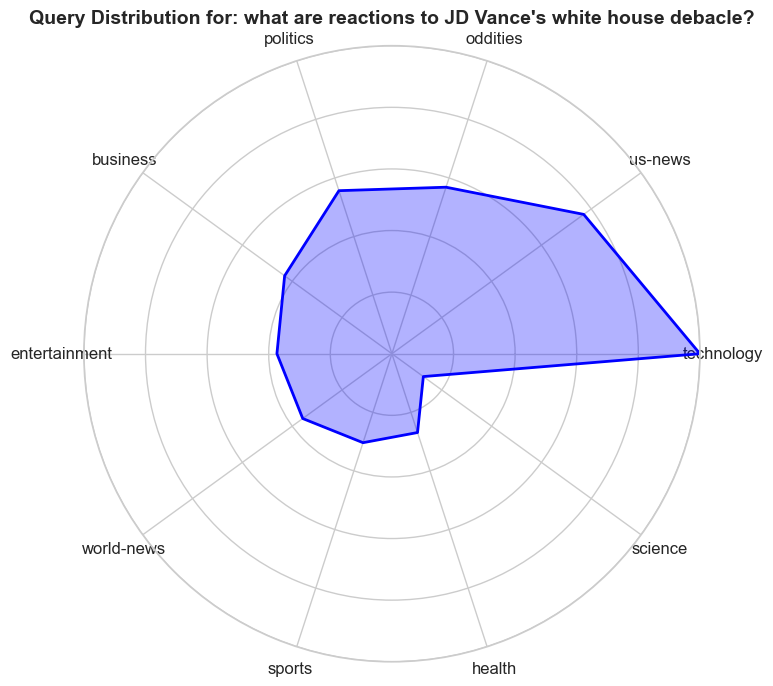


trump doge downsizing of food and drug administration ['health']


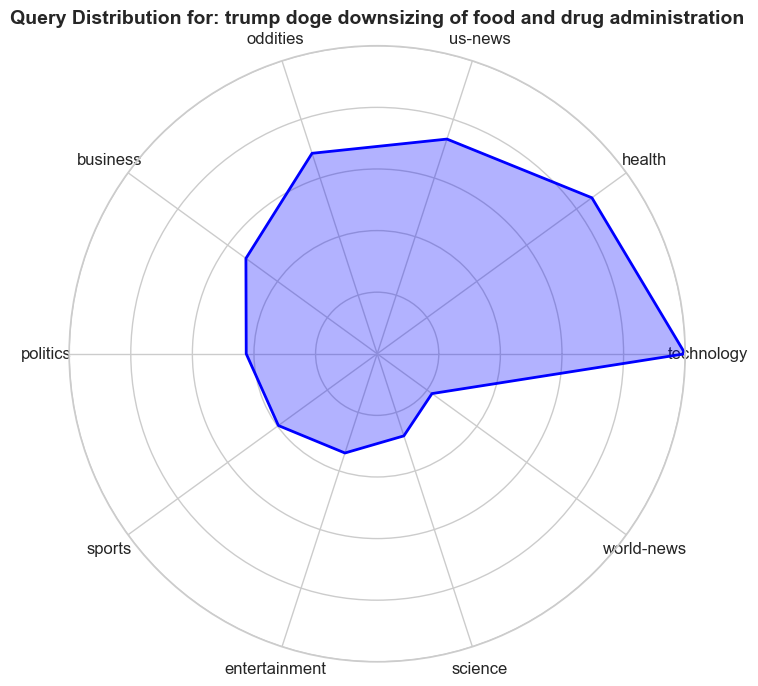


what are stores doing to battle inflation ['business']


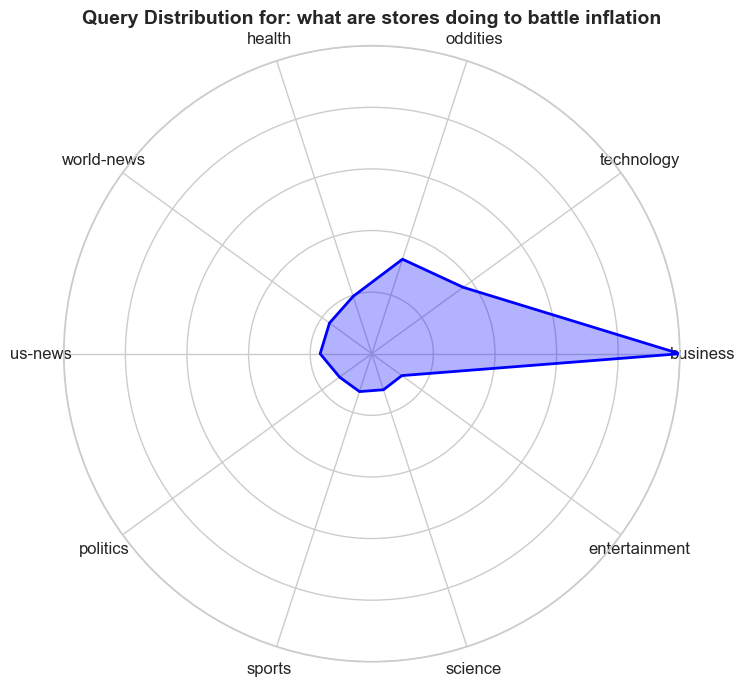

In [ ]:
for t in test_data:
    prompt = t[0]
    expected = t[1]
    print(prompt, expected)
    visualize_query_distribution(prompt)
    print()

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from newsies.chromadb_client import ChromaDBClient

# Initialize embedding model and ChromaDB client
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
chroma_client = ChromaDBClient()
chroma_client.collection_name = TAGS

# Output widget to prevent multiple plots
output = widgets.Output()


# Define a global list of all possible sections (to maintain order)
all_sections = set()  # Will be populated dynamically on first query

def plot_tfidf_distribution(prompt: str, top_n: int = 10):
    global all_sections

    with output:
        clear_output(wait=True)  # Prevent multiple plots from stacking

        # Encode the prompt
        prompt_embedding = embedding_model.encode(prompt).tolist()

        # Query ChromaDB for similar ngrams
        results = chroma_client.collection.query(
            query_embeddings=[prompt_embedding],
            n_results=top_n
        )

        # Aggregate TF-IDF scores by section
        section_scores = defaultdict(float)

        for metadata in results["metadatas"][0]:  # Assuming a single query
            if "tfidf" in metadata:
                section_tfidf = json.loads(metadata["tfidf"])
                for section, tfidf in section_tfidf.items():
                    if section != "oddities":
                        section_scores[section] += tfidf

        # Update global section list (ensuring stable order)
        all_sections.update(section_scores.keys())

        # Sort sections by name to maintain order
        sorted_sections = sorted(all_sections)

        # Ensure scores align to fixed section order
        values = [section_scores.get(section, 0) for section in sorted_sections]

        if not any(values):
            print("No matching n-grams found.")
            return

        # Radar chart setup
        angles = np.linspace(0, 2 * np.pi, len(sorted_sections), endpoint=False).tolist()
        values += [values[0]]  # Close the circle
        angles += [angles[0]]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.fill(angles, values, color='red', alpha=0.3)
        ax.plot(angles, values, color='red', linewidth=2)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(sorted_sections, fontsize=10, rotation=45, ha="right")
        plt.title(f"TF-IDF Distribution for Query: {prompt}", fontsize=14)
        plt.show()

In [6]:
# Interactive widget
prompt_input = widgets.Text(value="", description="Prompt:")
top_n_slider = widgets.IntSlider(value=10, min=5, max=5000, step=5, description="Top N:")

# Display the interactive elements and output
ui = widgets.VBox([prompt_input, top_n_slider])
display(ui, output)


# Attach event listener
def on_change(change):
    if change["name"] == "value":
        plot_tfidf_distribution(prompt_input.value, top_n_slider.value)

prompt_input.observe(on_change, names="value")
top_n_slider.observe(on_change, names="value")


Output()